JuanD Valenciano.
jvalenciano@unal.edu.co

//TODO. documentar............................


In [21]:
import os
######
import sys
from sys import platform  #Detect platform!
#sys.path.append('/content/drive/My Drive/Tesis/DatosAnalizar/ColabLib')    #Dir Lib!
######

#from numba import jit
import time
import torch 
import numpy as np
import itertools

import spectral.io.envi as envi
from spectral import *
import matplotlib
import matplotlib.pyplot as plt
import wx
from wx import glcanvas
import warnings
import pandas as pd
#from IPython.html.widgets import *
from ipywidgets import *
#from IPython.html.widgets import interact # IPython < 4.x
#import envi2
#from envi2.constants import *

import math
import pywt
import pywt.data

from sklearn.metrics import mean_squared_error as MSE
from scipy.stats     import median_absolute_deviation as MAD
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage import measure
##Error extrano al intentar cargar la libreria?/????
from skimage.measure import compare_psnr
from skimage.exposure import rescale_intensity

import cv2

'''
import LogWrite
from LogWrite.logWriter import *
import cv2
from google.colab import output
import time
from tqdm import tqdm
'''

'''
import pysptools.util as util
import pysptools.noise as ns
import pysptools.skl as skl
'''
from numpy.linalg import matrix_power




class UnsupportedPlatform(Exception):
    pass

In [42]:
#general functions.
average_function = np.nanmean

# Relation Signal noise 
def SNR(img):
    MeanValueImg = np.mean(img)
    StdValueImg = np.std(img)
    ValueSNR = MeanValueImg/StdValueImg
    return (ValueSNR)    

# equivalent number of looks
def ENL(img):
    MeanValueImg = np.mean(img)
    varValueImg = np.var(img)
    ValueENL = MeanValueImg**2/varValueImg**2
    return(ValueENL)

#Speckle suppression index
def SSI(imgOriginal, imgFilter):
    ValueSSI = (np.sqrt(np.std(imgFilter)**2)/np.mean(imgFilter))*(np.mean(imgOriginal)/np.sqrt(np.std(imgOriginal)**2))
    return(ValueSSI)

#Speckle suppression and mean preservation index
def SMPI(imgOriginal, imgFilter):
    MO = 1 + np.abs(np.mean(imgOriginal) - np.mean(imgFilter))
    ValueSMPI = MO * (np.sqrt(np.std(imgFilter)**2))/(np.sqrt(np.std(imgOriginal)**2))
    return(ValueSMPI)

def QualityFactor(imgOriginal, imgFilter):
    Y_S = np.mean(imgOriginal) - np.abs(np.mean(imgOriginal) - np.mean(imgFilter))
    LO = ENL(imgOriginal)
    VARF = np.var(imgFilter)
    MO = 1 + np.abs(np.mean(imgOriginal) - np.mean(imgFilter))
    ValueQ = Y_S**2/(LO*VARF**2)
    return(ValueQ)

def radiometricResponse(MinValue, MaxValue, DataRef, BlackRef, SpectralRef, IntegrationTime):
  ROUND_DECIMAL = 0   # 1.4 -> 1.0  |  1.5 -> 2.0
  N_ROWS, N_COLS, N_BANDS = DataRef.shape

  WhitedataTest = np.empty((N_ROWS, N_COLS, N_BANDS))
  WhitedataTest = DataRef[ MinValue:MaxValue, :,  :]

  Reference1 = np.uint16(np.round(WhitedataTest.sum(axis=0)/(MaxValue-MinValue), decimals=ROUND_DECIMAL))

  #New WhiteReference.
  N_ROWS = 1
  N_COLS = 1600
  N_BANDS = 160

  NW_WhiteReferenceArray = np.empty((N_ROWS, N_COLS, N_BANDS))
  NW_WhiteReferenceArray[0,:,:] = Reference1
  
  RadianceCamera = (NW_WhiteReferenceArray[:,:,:] - BlackRef[:,:,:])/(SpectralRef[:,1]*IntegrationTime)

  return (RadianceCamera)

def radiometricResponseOnePixelRef(DataRef, BlackRef, SpectralRef, IntegrationTime):
  ROUND_DECIMAL = 0   # 1.4 -> 1.0  |  1.5 -> 2.0
  N_ROWS, N_COLS, N_BANDS = DataRef.shape
  #TODO agregar la seleccion de banda.
  #New WhiteReference.
  N_ROWS = 1
  N_COLS = 1600
  N_BANDS = 160

  NW_WhiteReferenceArray = np.empty((N_ROWS, N_COLS, N_BANDS))
  for col in range(N_COLS):
    NW_WhiteReferenceArray[0,col,:] = DataRef[0, 0, :]

  RadianceCamera = (NW_WhiteReferenceArray[:,:,:] - BlackRef[:,:,:])/(SpectralRef[:,1]*IntegrationTime)

  return (RadianceCamera)

def radiometricCalibrationOnePixelREF(DataRef, BlackRef, SpectralRef, RadianceRef, IntegrationTime):
    N_ROWS, N_COLS, N_BANDS = DataRef.shape

    #RadianceCamera
    NewBlackReference = np.empty((N_ROWS, N_COLS, N_BANDS))
    NewRadianceCamera = np.empty((N_ROWS, N_COLS, N_BANDS))

    RadianceCamera = radiometricResponseOnePixelRef(RadianceRef, BlackRef, SpectralRef, IntegrationTime)
    #TODO fit with spectral signal.

    for row in range(N_ROWS):
      #print('row: ', row)
      NewBlackReference[row, :, :] = BlackRef[0,:,:]
      NewRadianceCamera[row, :, :] = RadianceCamera[0,:,:]

    dataTestCalibrada = np.empty((N_ROWS, N_COLS, N_BANDS))
    for bans in range(N_BANDS):
      dataTestCalibrada[:,:,bans] = (DataRef[:,:,bans] - NewBlackReference[:,:,bans])/(NewRadianceCamera[:,:,bans]*INTEGRATION_TIME)
  
    return (dataTestCalibrada)

def radiometricCalibrationArray(DataRef, BlackRef, RadianceRef, IntegrationTime):
    N_ROWS, N_COLS, N_BANDS = DataRef.shape

    #RadianceCamera
    NewBlackReference = np.empty((N_ROWS, N_COLS, N_BANDS))
    NewRadianceCamera = np.empty((N_ROWS, N_COLS, N_BANDS))

    for row in range(N_ROWS):
      #print('row: ', row)
      NewBlackReference[row, :, :] = BlackRef[0,:,:]
      for col in range(N_COLS):
        NewRadianceCamera[row, col, :] = RadianceRef[0,0,:]

    dataTestCalibrada = np.empty((N_ROWS, N_COLS, N_BANDS))
    for bans in range(N_BANDS):
      dataTestCalibrada[:,:,bans] = (DataRef[:,:,bans] - NewBlackReference[:,:,bans])/(NewRadianceCamera[:,:,bans]*INTEGRATION_TIME)
  
    return (dataTestCalibrada)

def QualityFactorPytorch(imgOriginal, imgFilter):
    Y_S = torch.mean(imgOriginal) - torch.abs(torch.mean(imgOriginal) - torch.mean(imgFilter))
    LO = ENL_Pytorch(imgOriginal)
    VARF = torch.var(imgFilter)
    MO = 1 + torch.abs(torch.mean(imgOriginal) - torch.mean(imgFilter))
    ValueQ =  Y_S**2/(LO*VARF**2)
    return(ValueQ)

def radiometricResponsePytorch(Pt1, Pt2, DataRef, BlackRef, SpectralRef, IntegrationTime):
    # creating a rectangle
    #          Col, Row
    #Point1 = (0,100)
    #Point2 = (1600, 150)

    WhitedataTest = DataRef[ Pt1[1]:Pt2[1], Pt1[0]:Pt2[0], :]

    Reference1 = torch.round(torch.sum(WhitedataTest ,0)/ (Pt2[1]-Pt1[1]))

    if((Pt2[0]-Pt1[0]) != 1600):
      Reference2 = torch.round(torch.sum(Reference1 ,0)/ (Pt2[0]-Pt1[0]))
      N_ROWS, N_COLS, N_BANDS = DataRef.size()
      N_ROWS = 1
      #NW_WhiteReferenceArray = torch.empty((N_ROWS, N_COLS, N_BANDS))
      NewRadianceCamera = torch.empty((N_ROWS, N_COLS, N_BANDS))
      for col in range(N_COLS):
        NewRadianceCamera[0, col, :] = (Reference2[:] - BlackRef[ 0, col, :])/(SpectralRef[:,1]*IntegrationTime)
      #print('NewRadianceCamera: ', NewRadianceCamera.size())
      #print('Reference2: ', Reference2.size())
      #print('size(): ', N_ROWS, N_COLS, N_BANDS)
    else:
      N_ROWS, N_COLS, N_BANDS = DataRef.size()
      N_ROWS = 1
      NewRadianceCamera = torch.empty((N_ROWS, N_COLS, N_BANDS))
      NewRadianceCamera[0,:,:] = (Reference1 - BlackRef[0,:,:])/(SpectralRef[:,1]*IntegrationTime) 
      #print('NewRadianceCamera: ', NewRadianceCamera.size())
    return(NewRadianceCamera)

def radiometricCalibrationPytorch(DataRef, BlackRef, RadianceRef, IntegrationTime):
    N_ROWS, N_COLS, N_BANDS = DataRef.size()
    dataTestCalibrada = torch.empty((N_ROWS, N_COLS, N_BANDS))
    for row in range(N_ROWS):
      dataTestCalibrada[row,:,:] = (DataRef[row,:,:] - BlackRef[0,:,:])/(RadianceRef[0,:,:]*IntegrationTime)
    return (dataTestCalibrada)

def allRadiometricCalibrationPytorch(Pt1, Pt2, DataRef, BlackRef, SpectralRef, IntegrationTime):
    ''' 
    MinValue = Espacio de la hoja de calibración Minimo.
    MaxValue = Espacio de la hoja de calibración Maximo.
    DataRef = Valores de los datos a calibrar
    BlackRef = valores del referencia.
    SpectralRef = valores de la hoja de calibración
    IntegrationTime = Timepo de integración, normalmente 16000
    '''
    Data1 = torch.from_numpy(np.float32(DataRef[:,:,:]))
    BlackReference = torch.from_numpy(np.float32(BlackRef[:,:,:]))
    spectralReference = torch.from_numpy(np.float32(SpectralRef[:]))
    
    RadianceCamera = radiometricResponsePytorch(Pt1, Pt2, Data1, BlackReference, spectralReference, IntegrationTime)
    dataTestCalibrada = radiometricCalibrationPytorch(Data1, BlackReference, RadianceCamera, IntegrationTime)
    #New WhiteReference.
    DataTommyCalibratePixelNoZero = np.copy(dataTestCalibrada.numpy())
    
    N_ROWS, N_COLS, N_BANDS = DataRef.shape

    for row in range(N_ROWS):
      for col in range(N_COLS):
        if(np.min(DataTommyCalibratePixelNoZero[row, col, :]) < 0):
          value = np.abs(np.min(DataTommyCalibratePixelNoZero[row, col, :]))
          DataTommyCalibratePixelNoZero[row, col, :] = DataTommyCalibratePixelNoZero[row, col, :] + value
    
    return (DataTommyCalibratePixelNoZero)

#def radiometricResponseNumpy(Pt1, Pt2, DataRef, BlackRef, SpectralRef, IntegrationTime):
def radiometricResponseNumpy( ArrayPoint, DataRef, BlackRef, SpectralRef, IntegrationTime, _DEBUG_ON = 0):    
    # creating a rectangle
    #          Col, Row
    #Point1 = (0,100)
    #Point2 = (1600, 150)
    
    ROUND_DECIMAL = 0   # 1.4 -> 1.0  |  1.5 -> 2.0
    
    if(_DEBUG_ON):
        print("> DEBUG_ON radiometricResponseNumpy: ")
        print(ArrayPoint.shape)
  
    CounterSignal  = ArrayPoint.shape[0]
    
    if(_DEBUG_ON):
        print("CounterSignal: ")
        print(CounterSignal)
    
    WhitedataTest  = 0.0       
    WhitedataTest1 = 0.0
    WhitedataTest2 = 0.0
    WhitedataTest2_Last = 0.0
    
    for CounterSignalFOR in range(CounterSignal):
        if(_DEBUG_ON):
            print("for(Solo_Uno_?):", str(CounterSignalFOR))
        WhitedataTest  = DataRef[   int(ArrayPoint[ int(CounterSignalFOR),0]): int(ArrayPoint[ int(CounterSignalFOR),2]),  int(ArrayPoint[ int(CounterSignalFOR),1]):int(ArrayPoint[ int(CounterSignalFOR),3]), :]
        #WhitedataTest1 = (np.round(WhitedataTest.sum(axis=0)/WhitedataTest.shape[0] ,decimals=ROUND_DECIMAL)).astype(int) 
        #WhitedataTest2 = (np.round(WhitedataTest1.sum(axis=0)/WhitedataTest1.shape[0] ,decimals=ROUND_DECIMAL)).astype(int)
        WhitedataTest1 = np.mean(WhitedataTest, axis=0).astype(float)
        WhitedataTest2 = np.mean(WhitedataTest1,axis=0).astype(float)        
        if(CounterSignalFOR>0):
            if(_DEBUG_ON):
                print("NO SE DEBE DE DAR ESTE CASO........")
                print("for + SUM", str(CounterSignalFOR))
            #WhitedataTest2 = (np.round(WhitedataTest1.sum(axis=0)/WhitedataTest1.shape[0] ,decimals=ROUND_DECIMAL)).astype(int)
            #WhitedataTest2 = (np.round(  (WhitedataTest2+WhitedataTest2_Last)/2    ,decimals=ROUND_DECIMAL)).astype(int)
            WhitedataTest2 = np.mean(WhitedataTest1,axis=0).astype(float)
            WhitedataTest2 = ((WhitedataTest2+WhitedataTest2_Last)/2).astype(float)
        WhitedataTest  = 0.0       
        WhitedataTest1 = 0.0
        WhitedataTest2_Last = WhitedataTest2                                                                                
    if(_DEBUG_ON):
        print("EndFor")
   
    #WhitedataTest  = DataRef[ Pt1[1]:Pt2[1], Pt1[0]:Pt2[0], :]
    #WhitedataTest1 = (np.round(WhitedataTest.sum(axis=0)/WhitedataTest.shape[0] ,decimals=ROUND_DECIMAL)).astype(int) 
    #WhitedataTest2 = (np.round(WhitedataTest1.sum(axis=0)/WhitedataTest1.shape[0] ,decimals=ROUND_DECIMAL)).astype(int) 
    
    
    N_ROWS, N_COLS, N_BANDS = DataRef.shape
    N_ROWS = 1
    N_COLS = 1
    #NW_WhiteReferenceArray = torch.empty((N_ROWS, N_COLS, N_BANDS))
    NewRadianceCamera = np.zeros((N_ROWS, N_COLS, N_BANDS))
    #for col in range(N_COLS):
    #    NewRadianceCamera[0, col, :] = (WhitedataTest2[:] - BlackRef[ 0, 0, :]) #/(SpectralRef[:,1]*IntegrationTime)    
    #NewRadianceCamera[0, 0, :] = np.clip( (WhitedataTest2[:] - BlackRef[ 0, 0, :])/(SpectralRef[:,1]*IntegrationTime), min=0)
    NewRadianceCamera[0, 0, :] = np.clip( ((WhitedataTest2[:] - BlackRef[ 0, 0, :])/(SpectralRef[:,1]*IntegrationTime)), a_min=0, a_max=None) 
    #NewRadianceCamera = NewRadianceCamera.clip(min=0)
    #NewRadianceCamera[0, 0, :] = (NewRadianceCamera[0, 0, :])/(SpectralRef[:,1]*IntegrationTime)
    #NewRadianceCamera = NewRadianceCamera.clip(min=0)
    
    N_ROWS, N_COLS, N_BANDS = DataRef.shape
    dataTestCalibrada = np.zeros((N_ROWS, N_COLS, N_BANDS))
    
    for row in range(N_ROWS):
        for col in range(N_COLS):
            dataTestCalibrada[row,col,:] = np.clip( (DataRef[row,col,:] - BlackRef[0,0,:])/(NewRadianceCamera[0,0,:]*IntegrationTime), a_min=0, a_max=None)
    
    #dataTestCalibrada = dataTestCalibrada.clip(min=0)
    #print(WhitedataTest.shape)
    #print(WhitedataTest.shape[2])
    #print(WhitedataTest1.shape)
    #print(WhitedataTest2.shape)
    #Reference1 = carlos_3_8_16000_17000__16000_us_2x_2020_01_27T202006_corr[:,:,:]
    #Reference2 = (np.round(Reference1.sum(axis=0)/carlos_3_8_16000_17000__16000_us_2x_2020_01_27T202006_corr.nrows ,decimals=ROUND_DECIMAL)).astype(int)
    #Reference5 = (np.round(Reference2.sum(axis=0)/carlos_3_8_16000_17000__16000_us_2x_2020_01_27T202006_corr.ncols ,decimals=ROUND_DECIMAL)).astype(int)
    ##return (NewRadianceCamera)
    return (dataTestCalibrada)

def radiometricResponseNumpyMEDIAN( ArrayPoint, DataRef, BlackRef, SpectralRef, IntegrationTime):    
    # creating a rectangle
    #          Col, Row
    #Point1 = (0,100)
    #Point2 = (1600, 150)
    
    ROUND_DECIMAL = 0   # 1.4 -> 1.0  |  1.5 -> 2.0
    
    print("Function radiometricResponseNumpy: ")
    print(ArrayPoint.shape)
  
    CounterSignal  = ArrayPoint.shape[0]
    print("CounterSignal: ")
    print(CounterSignal)
    
    WhitedataTest  = 0       
    WhitedataTest1 = 0
    WhitedataTest2 = 0
    WhitedataTest2_Last = 0
    
    for CounterSignalFOR in range(CounterSignal):
        print("for + ", str(CounterSignalFOR))
        WhitedataTest  = DataRef[   int(ArrayPoint[ int(CounterSignalFOR),0]): int(ArrayPoint[ int(CounterSignalFOR),2]),  int(ArrayPoint[ int(CounterSignalFOR),1]):int(ArrayPoint[ int(CounterSignalFOR),3]), :]
        #WhitedataTest1 = (np.round(WhitedataTest.sum(axis=0)/WhitedataTest.shape[0] ,decimals=ROUND_DECIMAL)).astype(int) 
        #WhitedataTest2 = (np.round(WhitedataTest1.sum(axis=0)/WhitedataTest1.shape[0] ,decimals=ROUND_DECIMAL)).astype(int)
        WhitedataTest1 = np.median(WhitedataTest, axis=0)
        WhitedataTest2 = np.median(WhitedataTest1,axis=0)        
        if(CounterSignalFOR>0):
            print("for + SUM", str(CounterSignalFOR))
            #WhitedataTest2 = (np.round(WhitedataTest1.sum(axis=0)/WhitedataTest1.shape[0] ,decimals=ROUND_DECIMAL)).astype(int)
            #WhitedataTest2 = (np.round(  (WhitedataTest2+WhitedataTest2_Last)/2    ,decimals=ROUND_DECIMAL)).astype(int)
            WhitedataTest2 = np.median(WhitedataTest1,axis=0)
            WhitedataTest2 = (WhitedataTest2+WhitedataTest2_Last)/2
        WhitedataTest  = 0       
        WhitedataTest1 = 0
        WhitedataTest2_Last = WhitedataTest2                                                                                
    print("EndFor")
   
    #WhitedataTest  = DataRef[ Pt1[1]:Pt2[1], Pt1[0]:Pt2[0], :]
    #WhitedataTest1 = (np.round(WhitedataTest.sum(axis=0)/WhitedataTest.shape[0] ,decimals=ROUND_DECIMAL)).astype(int) 
    #WhitedataTest2 = (np.round(WhitedataTest1.sum(axis=0)/WhitedataTest1.shape[0] ,decimals=ROUND_DECIMAL)).astype(int) 
    
    
    N_ROWS, N_COLS, N_BANDS = DataRef.shape
    N_ROWS = 1
    N_COLS = 1
    #NW_WhiteReferenceArray = torch.empty((N_ROWS, N_COLS, N_BANDS))
    NewRadianceCamera = np.zeros((N_ROWS, N_COLS, N_BANDS))
    #for col in range(N_COLS):
    #    NewRadianceCamera[0, col, :] = (WhitedataTest2[:] - BlackRef[ 0, 0, :]) #/(SpectralRef[:,1]*IntegrationTime)    
    #NewRadianceCamera[0, 0, :] = np.clip( (WhitedataTest2[:] - BlackRef[ 0, 0, :])/(SpectralRef[:,1]*IntegrationTime), min=0)
    NewRadianceCamera[0, 0, :] = np.clip( ((WhitedataTest2[:] - BlackRef[ 0, 0, :])/(SpectralRef[:,1]*IntegrationTime)), a_min=0, a_max=None) 
    #NewRadianceCamera = NewRadianceCamera.clip(min=0)
    #NewRadianceCamera[0, 0, :] = (NewRadianceCamera[0, 0, :])/(SpectralRef[:,1]*IntegrationTime)
    #NewRadianceCamera = NewRadianceCamera.clip(min=0)
    
    N_ROWS, N_COLS, N_BANDS = DataRef.shape
    dataTestCalibrada = np.zeros((N_ROWS, N_COLS, N_BANDS))
    
    for row in range(N_ROWS):
        for col in range(N_COLS):
            dataTestCalibrada[row,col,:] = np.clip( (DataRef[row,col,:] - BlackRef[0,0,:])/(NewRadianceCamera[0,0,:]*IntegrationTime), a_min=0, a_max=None)
    
    #dataTestCalibrada = dataTestCalibrada.clip(min=0)
    #print(WhitedataTest.shape)
    #print(WhitedataTest.shape[2])
    #print(WhitedataTest1.shape)
    #print(WhitedataTest2.shape)
    #Reference1 = carlos_3_8_16000_17000__16000_us_2x_2020_01_27T202006_corr[:,:,:]
    #Reference2 = (np.round(Reference1.sum(axis=0)/carlos_3_8_16000_17000__16000_us_2x_2020_01_27T202006_corr.nrows ,decimals=ROUND_DECIMAL)).astype(int)
    #Reference5 = (np.round(Reference2.sum(axis=0)/carlos_3_8_16000_17000__16000_us_2x_2020_01_27T202006_corr.ncols ,decimals=ROUND_DECIMAL)).astype(int)
    ##return (NewRadianceCamera)
    return (dataTestCalibrada)

def SNR(A,B):
  A_p = np.sum(np.power( A, 2))
  B_p = np.sum(np.power(B-A, 2))
  valueSNR = A_p/B_p
  return (valueSNR)


#Load data!!!!!!!!!!!

In [31]:

diseased_group_sample_1 = []
diseased_group_sample_2 = []
diseased_group_sample_3 = []
diseased_group_sample_4 = []
diseased_group_sample_5 = []

if "linux" in platform:
    print("linux GREAT :)")
    #relative folder!!!!!!!!!!
    ###################################### ONLY FOR diseased_group ###############################################################
    tmpDataFolder_PATH = '/home/juandval/GitHub/UNAL/GoogleDrive/tommy/diseased_group/'
    
    for entry in os.listdir(tmpDataFolder_PATH):
        #print('Firt entry: ', entry)
        for inEntry in os.listdir(tmpDataFolder_PATH + entry + '/'):
            if(inEntry.endswith('.hdr')):
                #print('OK file: ', inEntry.strip('hdr').strip('.'))
                relative_PATH    = tmpDataFolder_PATH + entry + '/' + inEntry.strip('hdr').strip('.')
                if(entry == 'sample_1'):
                    diseased_group_sample_1.append(envi.open(relative_PATH + '.hdr', relative_PATH + '.hyspex'))
                elif(entry == 'sample_2'):
                    diseased_group_sample_2.append(envi.open(relative_PATH + '.hdr', relative_PATH + '.hyspex'))
                elif(entry == 'sample_3'):
                    diseased_group_sample_3.append(envi.open(relative_PATH + '.hdr', relative_PATH + '.hyspex'))
                elif(entry == 'sample_4'):
                    diseased_group_sample_4.append(envi.open(relative_PATH + '.hdr', relative_PATH + '.hyspex'))
                elif(entry == 'sample_5'):
                    diseased_group_sample_5.append(envi.open(relative_PATH + '.hdr', relative_PATH + '.hyspex'))
                else:
                    print('>>>>>>>>>>>>> ERROR_01 >>>>>>>>>>>>>')
    #############################################################################################################################
    #Datos Almacenados en WS
    # Black Reference and spectral target.
    BlackReference_PATH     = '/home/juandval/GitHub/UNAL/GoogleDrive/Tools/BlackReference_Single'
    BLACK_REF_IMG      = envi.open( BlackReference_PATH + '.hdr', BlackReference_PATH + '.hyspex')
    
    spectral_target_PATH    = '/home/juandval/GitHub/UNAL/GoogleDrive/Tools/spectra_target'
    dataSpectralTarget = pd.read_csv( spectral_target_PATH + '.csv',   header=None)
    
    #Spectral reference.
    N_COLS  = 2
    N_ROWS  = 160

    SpectralReference = np.empty((N_ROWS, N_COLS))
    SpectralReference[:,0] = dataSpectralTarget[0] #Copy wn
    SpectralReference[:,1] = dataSpectralTarget[1] #Copy Radiance
    
    IntegrationTime = 16000
    #############################################################################################################################
    #Print Load Data.....
    print('####################################################################################################################')
    print('Lenght Sample_1: ' + str(len(diseased_group_sample_1)))
    print('--------------------------------------------------------------------------------------------------------------------')
    print(diseased_group_sample_1)
    
    print('####################################################################################################################')
    print('Lenght Sample_2: ' + str(len(diseased_group_sample_2)))
    print('--------------------------------------------------------------------------------------------------------------------')
    print(diseased_group_sample_2)
    
    print('####################################################################################################################')
    print('Lenght Sample_3: ' + str(len(diseased_group_sample_3)))
    print('--------------------------------------------------------------------------------------------------------------------')
    print(diseased_group_sample_3)
    
    print('####################################################################################################################')
    print('Lenght Sample_4: ' + str(len(diseased_group_sample_4)))
    print('--------------------------------------------------------------------------------------------------------------------')
    print(diseased_group_sample_4)
    
    print('####################################################################################################################')
    print('Lenght Sample_5: ' + str(len(diseased_group_sample_5)))
    print('--------------------------------------------------------------------------------------------------------------------')
    print(diseased_group_sample_5)
    print('####################################################################################################################')
    
elif "darwin" in platform:
    print("mac")
    print("No support!!!!!!")
elif "win" in platform:
    print("windows TAAAA :(")
    
else:
    raise UnsupportedPlatform
    
    
    

linux GREAT :)
####################################################################################################################
Lenght Sample_1: 6
--------------------------------------------------------------------------------------------------------------------
[	Data Source:   '/home/juandval/GitHub/UNAL/GoogleDrive/tommy/diseased_group/sample_1/tom_dgs_01_16000_us_2x_2019-11-25T122944_corr.hyspex'
	# Rows:           3800
	# Samples:        1600
	# Bands:           160
	Interleave:        BIL
	Quantization:  16 bits
	Data format:    uint16, 	Data Source:   '/home/juandval/GitHub/UNAL/GoogleDrive/tommy/diseased_group/sample_1/tom_dgs_01_16000_us_2x_2019-11-24T135629_corr.hyspex'
	# Rows:           3800
	# Samples:        1600
	# Bands:           160
	Interleave:        BIL
	Quantization:  16 bits
	Data format:    uint16, 	Data Source:   '/home/juandval/GitHub/UNAL/GoogleDrive/tommy/diseased_group/sample_1/tom_dgs_01_16000_us_2x_2019-11-28T172239_corr.hyspex'
	# Rows:           38

In [25]:
################################################################
img_selection = 1
DataRAW       = diseased_group_sample_1[img_selection]
################################################################

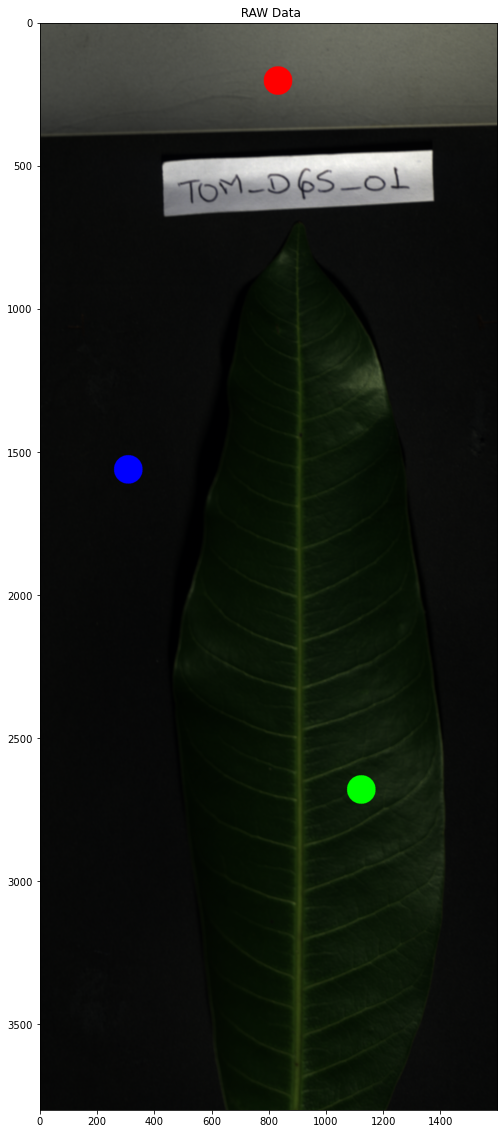

In [26]:
#print('Lenght Sample_1: ' + str(len(diseased_group_sample_1)))
#print('--------------------------------------------------------------------------------------------------------------------')
#print(diseased_group_sample_1)

img_selection = 1

#Plot Scena.
#RGB with CalibrationPoin and MASK
N_ROWS  = DataRAW.nrows
N_COLS  = DataRAW.ncols
N_BANDS = 3 #?????

dataRGB = np.zeros(( N_ROWS, N_COLS, N_BANDS), dtype=np.float32)
dataRGB = get_rgb(DataRAW,[55,41,12])

dataRGB_uint8_t = rescale_intensity( dataRGB, out_range=(0, 255)).astype(np.uint8).copy()

# creating a rectangle
#         Col, Row
X1 = ( int(831), int(204))
Y1 = ( int(831), int(204))

X2 = ( int(1122), int(2680))
Y2 = ( int(1122), int(2680))

X3 = ( int(308), int(1562))
Y3 = ( int(308), int(1562))

cv2.rectangle(dataRGB_uint8_t, X1, Y1, (255, 0, 0), 100)
cv2.rectangle(dataRGB_uint8_t, X2, Y2, (0, 255, 0), 100)
cv2.rectangle(dataRGB_uint8_t, X3, Y3, (0, 0, 255), 100)
        
plt.figure(figsize=(30,20))
plt.imshow(dataRGB_uint8_t), plt.title(' RAW Data')
plt.show()  



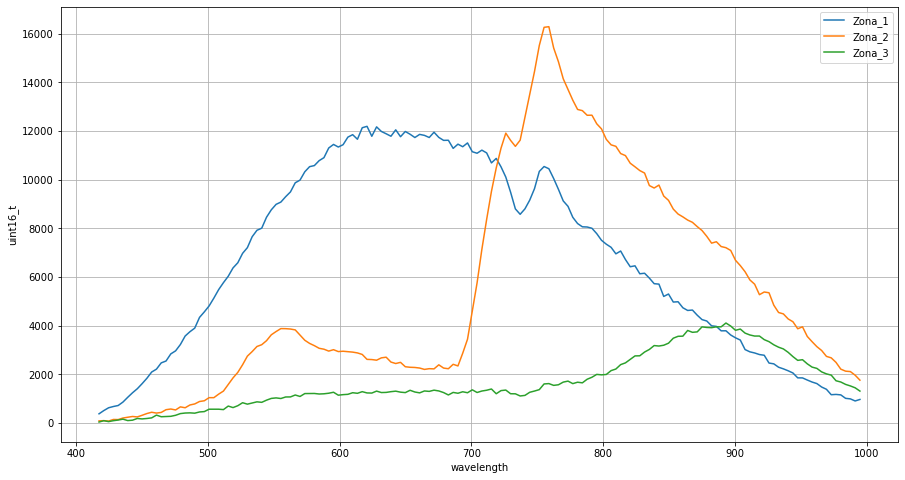

In [27]:
#Plot espectral.

Pixel_Y_Point1 = 204
Pixel_X_Point1 = 831

Pixel_Y_Point2 = 2680
Pixel_X_Point2 = 1122

Pixel_Y_Point3 = 1562
Pixel_X_Point3 = 308

#For use Plot Fuction!

WN_BANDS = (DataRAW.bands.centers)


plt.figure(figsize=(15,8))

plt.plot( WN_BANDS, DataRAW.read_pixel( Pixel_Y_Point1, Pixel_X_Point1), label='Zona_1')
plt.plot( WN_BANDS, DataRAW.read_pixel( Pixel_Y_Point2, Pixel_X_Point2), label='Zona_2')
plt.plot( WN_BANDS, DataRAW.read_pixel( Pixel_Y_Point3, Pixel_X_Point3), label='Zona_3')

plt.grid()
plt.xlabel('wavelength')
plt.ylabel('uint16_t')
plt.legend()
plt.show()

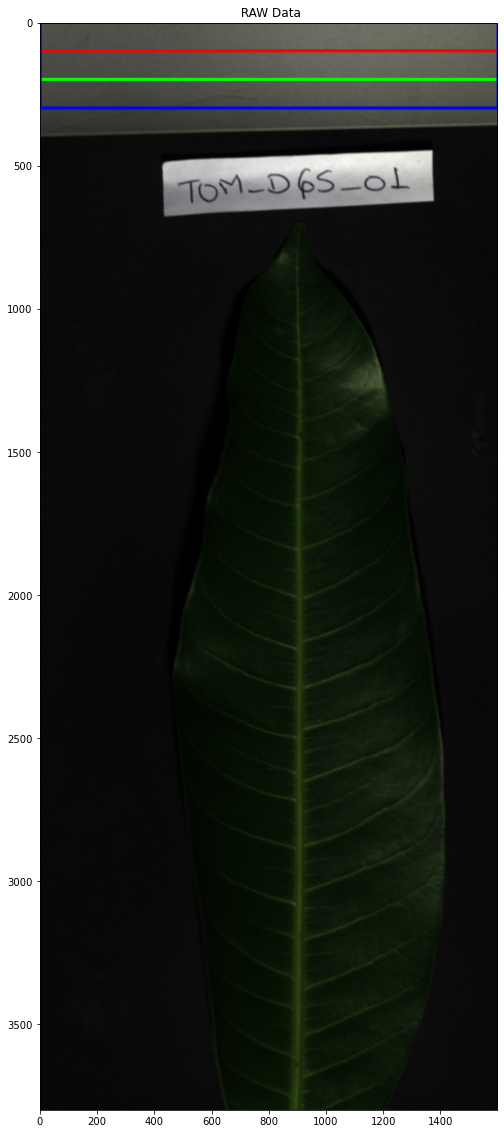

"\nData_Sin_Sombra_EXP_01 = {}\nCounter = 0\nfor obj in Ref_PATH_GoogleDrive: \n    print('Descargando Datos en WS: ', obj)\n    os.system('rclone copy remote:Tesis/DatosAnalizar/Compartido\\ \\por\\ \\JuanDVal/SoftwareHyspex/Datos/Sin_Sombra/'+obj+'.hdr '+tmpDataFolder)\n    os.system('rclone copy remote:Tesis/DatosAnalizar/Compartido\\ \\por\\ \\JuanDVal/SoftwareHyspex/Datos/Sin_Sombra/'+obj+'.img '+tmpDataFolder)\n    print('path de trabajo: ', tmpDataFolder+Ref_PATH_GoogleDriveNAME+'.hdr')\n    print('path de trabajo: ', tmpDataFolder+Ref_PATH_GoogleDriveNAME+'.hyspex')\n    #Hola = envi.open( tmpDataFolder+obj+'.hdr', tmpDataFolder+obj+'.hyspex')\n    Data_Sin_Sombra_EXP_01[Counter] = envi.open( FulltmpDataFolder+Ref_PATH_GoogleDriveNAME+'.hdr', FulltmpDataFolder+Ref_PATH_GoogleDriveNAME+'.img')\n    print('Borrando Datos en WS: ', obj)\n    os.remove(FulltmpDataFolder+Ref_PATH_GoogleDriveNAME+'.hdr')\n    os.remove(FulltmpDataFolder+Ref_PATH_GoogleDriveNAME+'.img')\n    Counter+=

In [28]:
#Plot CalView
#Calibración de datos.
'''
Data_Sin_Sombra_EXP_01_toTest = {}
ArrayCalPoint = np.zeros(( int(3),4))

ArrayCalPoint[0, 0] = 0
ArrayCalPoint[0, 1] = 0
ArrayCalPoint[0, 2] = 1600
ArrayCalPoint[0, 3] = 100
'''
#Plot Scena.
#RGB with CalibrationPoin and MASK
N_ROWS  = DataRAW.nrows
N_COLS  = DataRAW.ncols
N_BANDS = 3
    
dataRGB = np.zeros(( N_ROWS, N_COLS, N_BANDS), dtype=np.float32)
dataRGB = get_rgb(DataRAW)

dataRGB_uint8_t = rescale_intensity( dataRGB, out_range=(0, 255)).astype(np.uint8).copy()

# creating a rectangle
#         Col, Row
X1 = ( int(0), int(0))
Y1 = ( int(1600), int(100))

X2 = ( int(0), int(0))
Y2 = ( int(1600), int(200))

X3 = ( int(0), int(0))
Y3 = ( int(1600), int(300))

cv2.rectangle(dataRGB_uint8_t, X1, Y1, (255, 0, 0), 10)
cv2.rectangle(dataRGB_uint8_t, X2, Y2, (0, 255, 0), 10)
cv2.rectangle(dataRGB_uint8_t, X3, Y3, (0, 0, 255), 10)
        
plt.figure(figsize=(30,20))
plt.imshow(dataRGB_uint8_t), plt.title(' RAW Data')
plt.show()  

'''
Data_Sin_Sombra_EXP_01 = {}
Counter = 0
for obj in Ref_PATH_GoogleDrive: 
    print('Descargando Datos en WS: ', obj)
    os.system('rclone copy remote:Tesis/DatosAnalizar/Compartido\ \por\ \JuanDVal/SoftwareHyspex/Datos/Sin_Sombra/'+obj+'.hdr '+tmpDataFolder)
    os.system('rclone copy remote:Tesis/DatosAnalizar/Compartido\ \por\ \JuanDVal/SoftwareHyspex/Datos/Sin_Sombra/'+obj+'.img '+tmpDataFolder)
    print('path de trabajo: ', tmpDataFolder+Ref_PATH_GoogleDriveNAME+'.hdr')
    print('path de trabajo: ', tmpDataFolder+Ref_PATH_GoogleDriveNAME+'.hyspex')
    #Hola = envi.open( tmpDataFolder+obj+'.hdr', tmpDataFolder+obj+'.hyspex')
    Data_Sin_Sombra_EXP_01[Counter] = envi.open( FulltmpDataFolder+Ref_PATH_GoogleDriveNAME+'.hdr', FulltmpDataFolder+Ref_PATH_GoogleDriveNAME+'.img')
    print('Borrando Datos en WS: ', obj)
    os.remove(FulltmpDataFolder+Ref_PATH_GoogleDriveNAME+'.hdr')
    os.remove(FulltmpDataFolder+Ref_PATH_GoogleDriveNAME+'.img')
    Counter+=1
#Datos almacenados en Data segun el orden descaargado. 
''' 

In [44]:
#radiometricResponseNumpy TEST FC DEBUG_ON = 1

print(DataRAW.shape)

Data_Sin_Sombra_EXP_01_toTest = {}

ArrayCalPoint = np.zeros(( int(1),4))
ArrayCalPoint[0, 0] = 0
ArrayCalPoint[0, 1] = 0
ArrayCalPoint[0, 2] = 100
ArrayCalPoint[0, 3] = 1600

Counter = 1

for i in range(Counter):    
    print('Data Cal on Y: ', str(ArrayCalPoint[0,2]))
    print(ArrayCalPoint)
    Data_Sin_Sombra_EXP_01_toTest[i] = radiometricResponseNumpy( ArrayCalPoint, DataRAW[0:1000,:,:], BLACK_REF_IMG[:,:,:], SpectralReference, IntegrationTime, 1)
    ArrayCalPoint[0, 2] = 100 + ArrayCalPoint[0, 2]

(500, 1600, 160)
Data Cal on Y:  100.0
[[   0.    0.  100. 1600.]]
> DEBUG_ON radiometricResponseNumpy: 
(1, 4)
CounterSignal: 
1
for(Solo_Uno_?): 0
EndFor


In [39]:
####### Clean RAM................
del Data_Sin_Sombra_EXP_01_toTest